# FIT5201_2018S2 Assignment 2 - Section B - Question 2

- <font color='blue'>**Student Id**</font>: 27771539
- <font color='blue'>**Student Name**</font>: Chuangfu Xie
- <font color='blue'>**Packages in use**</font>:
    - `repr`: Provide more control on graphical presentation
    - `ggplot2`: Data visualization package

## 0. Import packages:

In [35]:
library(repr)
library(ggplot2)
library(reshape2)

Configure the plot setting: 

In [147]:
options(repr.plot.width=8, repr.plot.height=8)

## 1. Plotting Data

In [37]:
train <- read.csv('./datasets/Task2B_train.csv')
test <- read.csv('./datasets/Task2B_test.csv')
# remove NAs
train <- train[complete.cases(train), ]
test <- test[complete.cases(test), ]

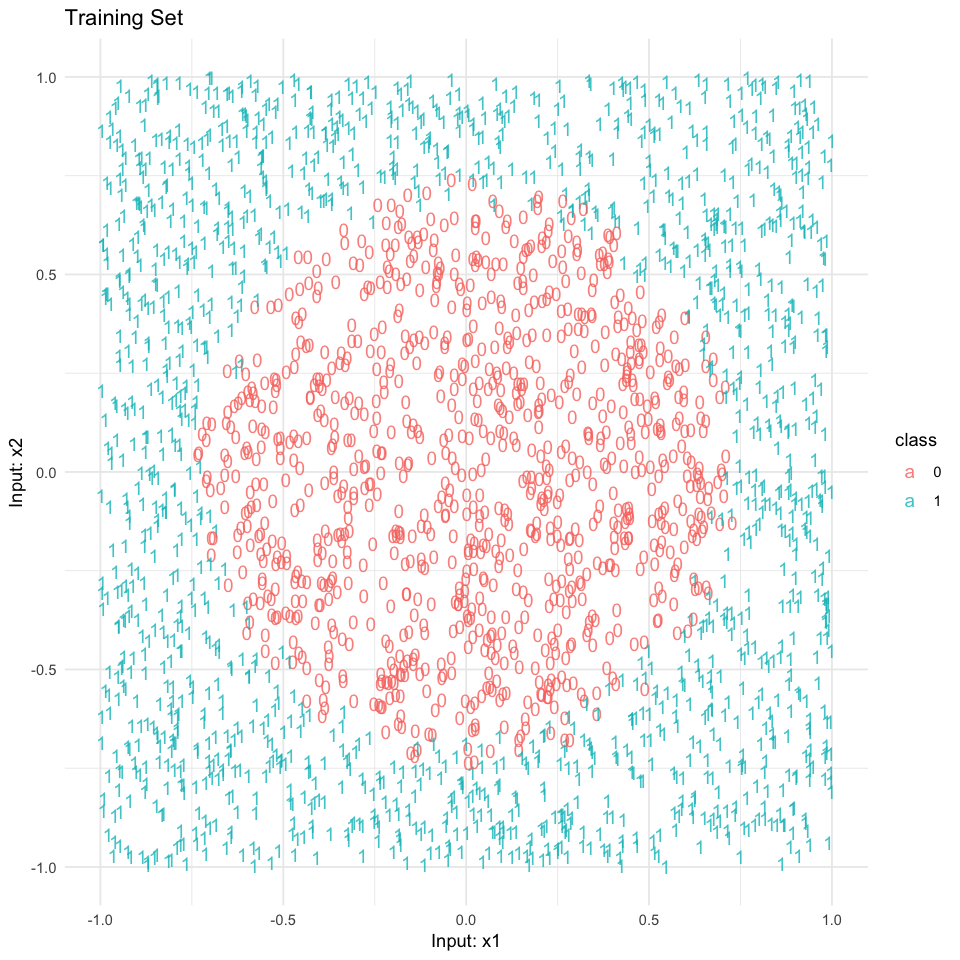

In [148]:
c0 <- '0'; c1 <- '1'
ggplot(data=train, aes(x=x1, y=x2, color=as.factor(y), label=ifelse(y==c0, '0', '1'))) +
    geom_text(size = 4, alpha=0.8) + labs(x='Input: x1', y='Input: x2', color="class") +
    ggtitle ('Training Set') + theme_minimal()

## 2. Perceptron

### 2.0 Anxilary functions

In [39]:
perceptron.predict <- function(Phi, W){
    # perceptron criterion
    return(ifelse(Phi%*%W>=0, +1, -1))
}

is.a.miss <- function(Phi, W, T1){
    # misclassification helper
    return((W %*% Phi) * T1 < 0)
}

error.rate <- function(Y1, T1){
    if (length(Y1)!=length(T1)){
        stop('error.rate: size of true lables and predicted labels mismatch')
    }
    return (sum(T1!=Y1)/length(T1))
}

### 2.1 Perceptron function

In [43]:
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
    if (length(unique(T1))!=2){
        stop("Perceptron: The input data is not a binary classification problem.")
    }
    
    if (all(sort(unique(T1)) != c(-1, 1))) {
        stop("Perceptron: The labels are not (-1, +1).")
    }
    # total number of data
    N1 <- nrow(X1)
    # add the bias
    Phi <- as.matrix(cbind(1, X1))
    
    # Empty Weight vector
    W <- matrix(NA, nrow=tau.max, ncol=ncol(Phi))
    # Random initial values for weight vector (Perceptron is sensitive to it)
    # or you can set up seed to make the ideal result reproducible
    # set.seed(12345)
    W[1,] <- 2*runif(ncol(Phi))-1
    
    # Placeholder for errors
    error.rec <- matrix(NA,nrow=tau.max, ncol=1)
    # Record error for initial weights
    error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1)
    
    # Iteration counter 
    tau <- 1
    # Termination status
    terminate <- FALSE

    while(!terminate){
        # Resuffling train data and associated labels
        indx <- sample(1:N1, replace = FALSE)
        Phi <- Phi[indx,]
        T1 <- T1[indx]

        for (i in 1:N1){
        if (tau >= tau.max) {break}
            # Look for missclassified samples
            if (is.a.miss(Phi[i,], W[tau,], T1[i])){
                # Update tau counter
                tau <- tau +1
                # Update the weights
                W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]
                # Update the records
                error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)
                # Decrease eta
                eta = eta * 0.99
            }
        }
     
        # recalculate termination conditions
        cond1 <- (tau >= tau.max)
        cond2 <- (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
        terminate <- cond1 | cond2
    }
    
    if (plotting){
        plot(error.rec[complete.cases(error.rec),], type="l", xlab = 'tau', ylab = 'error', main = 'Perceptron')
    }
    
    # cut the empty part of the matrix when the loop stops before tau == tau.max
    W <- W[complete.cases(W),]
    # print out
    cat('The final result: ', W[nrow(W),])
    # return the last wight vector
    return(W[nrow(W),])
}

### 2.2 Run the code

In [44]:
# pre-processing
train.len <- nrow(train)
# extract x1,x2 only 
train.data <- train[,-3]
# extract y
train.label <- train[, 3]
# using perceptron criterion, replace 0 with -1
train.label <- replace(train.label, train.label==0, -1)

test.data <- test[, -3]
test.label <- test[, 3]
# add the bias before predict
test.data <- as.matrix(cbind(1, test.data))
# using perceptron criterion, replace 0 with -1    
test.label <- replace(test.label, test.label==0, -1)

Note: Perceptron is sensitive to initial weights. Run a few time to get a resonable result and plots.

The final result:  -0.07285259 0.3459498 -0.1019772

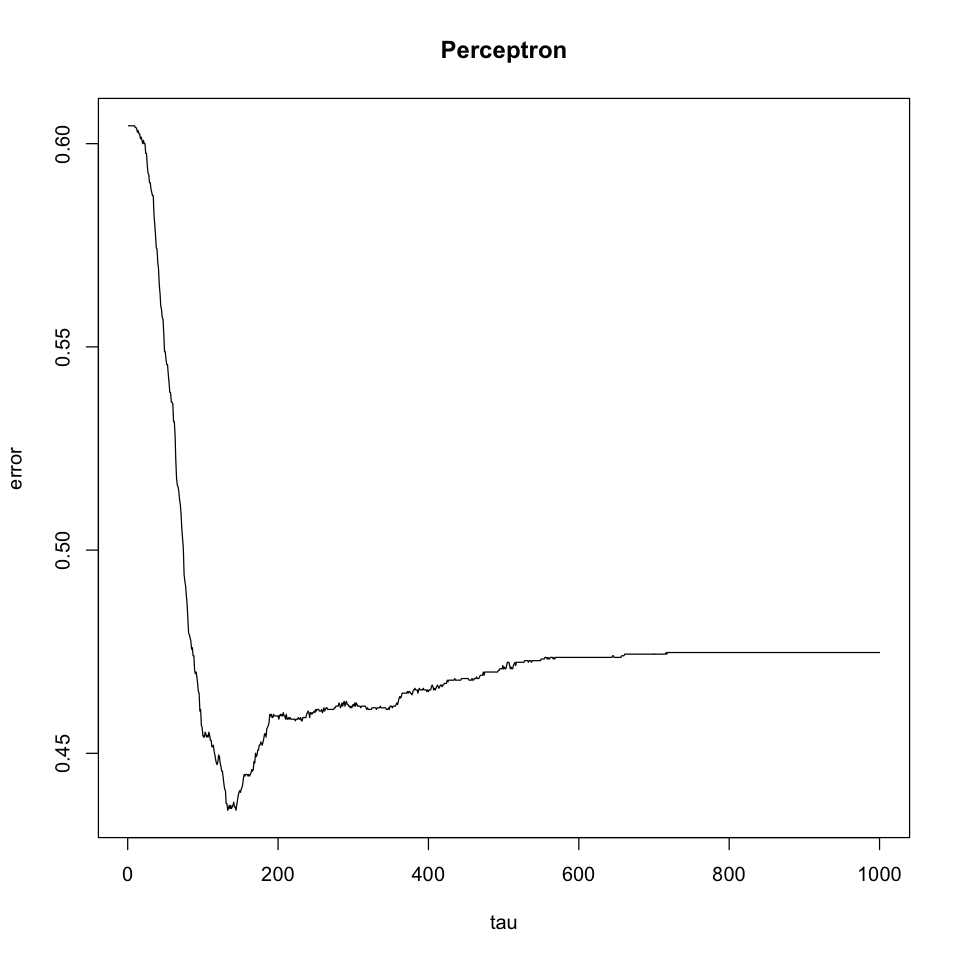

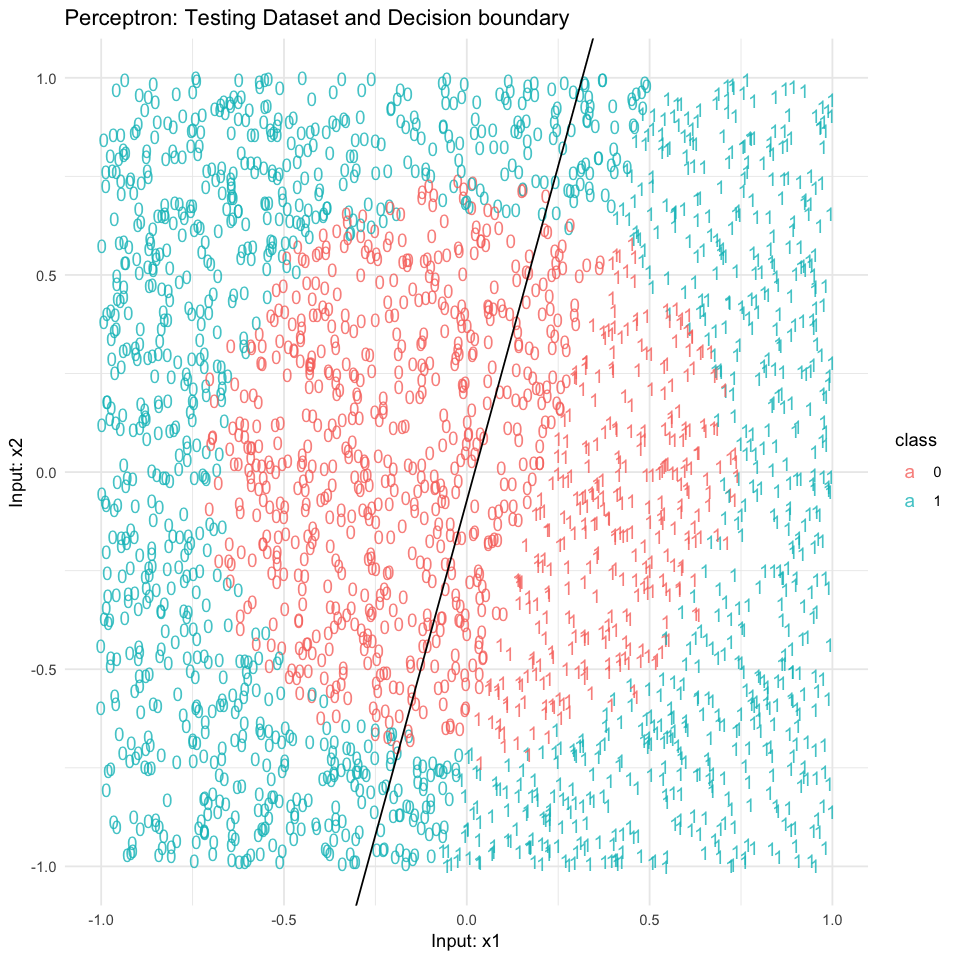

In [71]:
W <- perceptron.build(train.data, train.label, tau.max = 1000, plotting = TRUE) 
pred = ifelse(test.data %*% W >0, '1', '0')
ggplot(data=test, aes(x=x1, y=x2, color=as.factor(y), label=as.factor(pred))) +
    geom_text(size = 4, alpha=0.8) + 
    geom_abline(intercept = W[1], slope = -W[2]/W[3]) +
    labs(x='Input: x1', y='Input: x2', color="class") +
    ggtitle ('Perceptron: Testing Dataset and Decision boundary') + theme_minimal()


### 2.3 Conclusion:

According to the perceptron convergence theorem, if there exists an exact solution, the perceptron learning algorithm is guaranteed to find an exact solution in a finite number of steps. In other words, if the problem itself is linear separable, the perceptron algorithm always converge and find the optimal solution. Apparently, the dataset we use in this section, though it is a binary classification problem, the problem is not linear separable. That is why the error will bounce back. 

## 3. Neural Network 

### 3.0 Auxilary functions

In [73]:
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# the activation function 
h <- function(z, a=1) { #activation function (sigmoid here)
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}

# the derivitive of the activation function (tanh here)
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}

# class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}

# prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}

# feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}

# backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}

### 3.1 Neural Network

In [74]:
nn.build <- function(K, X1, T1, epoch.max=50, eta = 0.1, lambda = 0.01){
   # initialization
   D <- nrow(X1)
   if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
   N <- ncol(X1)
 
   W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
   b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
   W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
   b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

   for (epoch in 1:epoch.max){   
        ## delta vectors/matrices initialization
        W1.d <- W1 *0
        b1.d <- b1 *0
        W2.d <- W2 *0
        b2.d <- b2 *0

        for (i in 1:N){
              ## Feedforward:
              list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
              ## Backpropagation:
              list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
              ## calculate the delta values
              ### 1st layer
              W1.d <- W1.d + d2 %*% t(a1)
              b1.d <- b1.d + d2
              ### 2nd layer
              W2.d <- W2.d + d3 %*% t(a2)
              b2.d <- b2.d + d3
        }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
   }
  return(list('w1'=W1, 'w2'=W2, 'b1'=b1, 'b2'=b2))
}

### 3.2 Run the code

In [77]:
# initialise an empty matrix to record the test error for each k
errors <- matrix(NA, nrow=50, ncol=1)    
# calculate error in each k (it will take few hours to finish the calculation)
for (i in 1:50){
    k <- 2*i
    list[W1, W2, b1, b2] <- nn.build(K=k, X1 = t(train.data), T1 = train.label, epoch.max=300)
    errors[i]<- error.rate(nn.predict(t(test.data[,2:ncol(test.data)]), W1, W2, b1, b2), test.label)
}

In [149]:
# for plotting
errors.m <-data.frame(k=seq(2,100,2), E=errors)
# store the best k and the error for plotting
best_K <- data.frame(x=2*which.min(errors), y=errors[which.min(errors)])

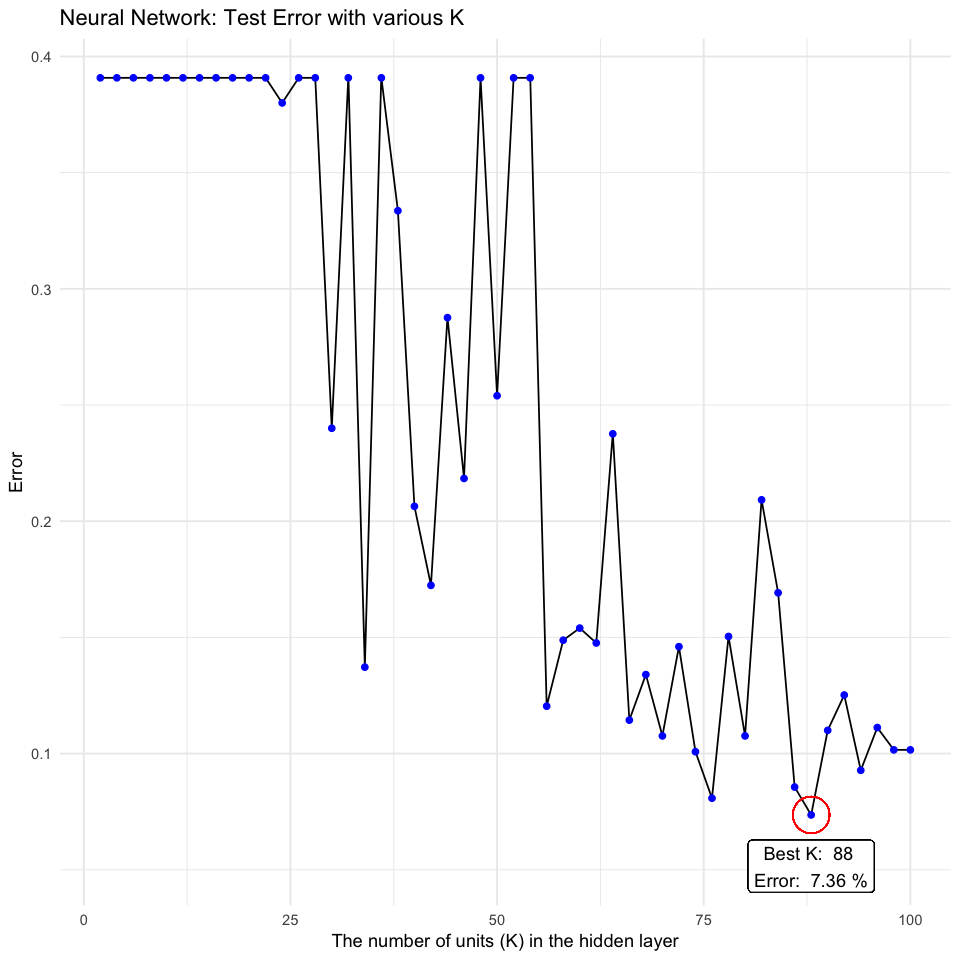

In [157]:
ggplot(data=errors.m, aes(x=k, y=E)) + labs(x='The number of units (K) in the hidden layer', y='Error') + 
    ggtitle ('Neural Network: Test Error with various K') + 
    geom_line() +
    geom_point(colour='blue') +
    geom_point(aes(x=best_K$x, y=best_K$y), size = 10, colour="red", shape=1) +
    geom_label(aes(x=best_K$x, y=0.7*best_K$y), 
               label = paste("Best K: ",best_K$x, '\nError: ', 100 * best_K$y, '%'))+
    theme_minimal()

In [154]:
# extract the best k value
list[W1, W2, b1, b2] <- nn.build(K=best_K$x, X1 = t(train.data), T1 = train.label, epoch.max=300)

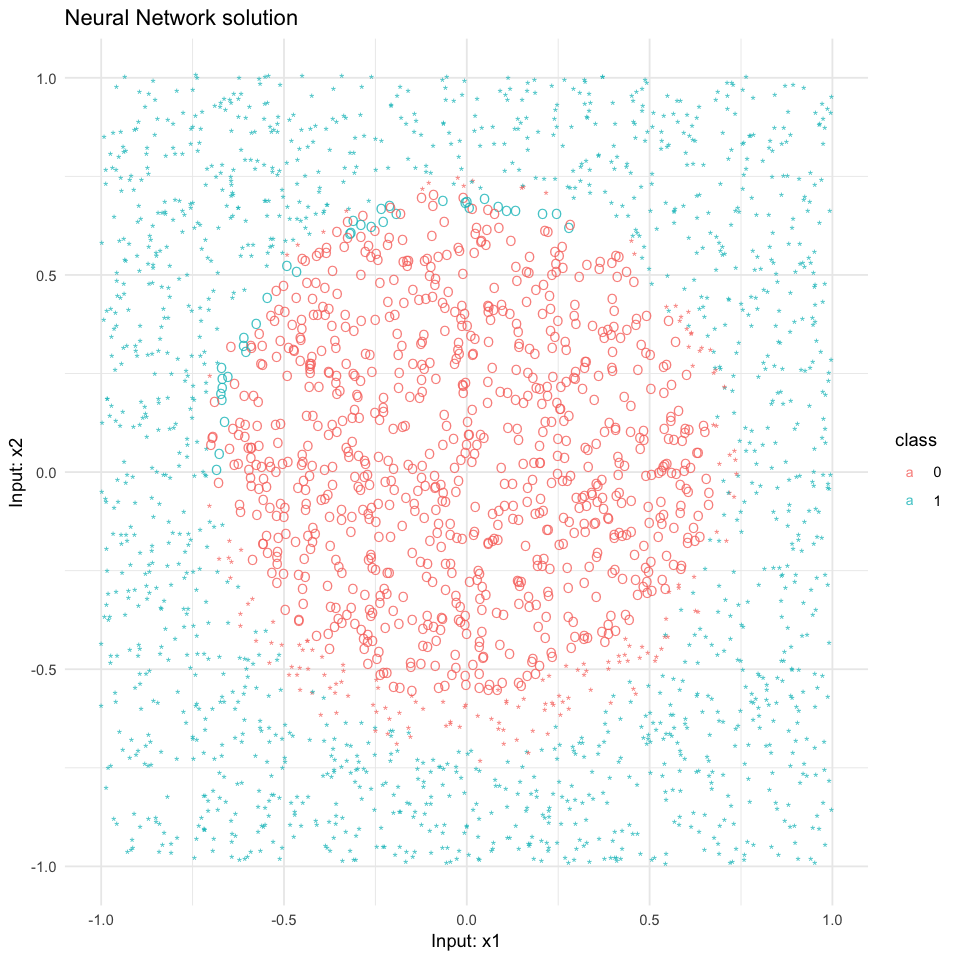

In [159]:
# use the weight to calculate the predition
pred <- as.numeric(nn.predict(t(test.data[,2:ncol(test.data)]), W1, W2, b1, b2))
pred <- as.factor(ifelse(pred == 1, '*', 'O'))
ggplot(data=test, aes(x=x1, y=x2, color=as.factor(y), label=as.factor(pred))) +
    geom_text(size = 3, alpha=0.8) + 
    labs(x='Input: x1', y='Input: x2', color="class") +
    ggtitle ('Neural Network solution') + theme_minimal()

### 3.3 Conclusion

Compare with the perceptron algorithm, neural network can solve the linear non-separable problem with high accuracy. It is becasue NN is not a linear classifier as its counterpart.